In [2]:
!pip3 install tensorflow --quiet
!pip3 install datasets --quiet
!pip3 install transformers --quiet
!pip3 install tf_keras --quiet

In [3]:
import pandas as pd
import numpy as np

import boto3
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
import torch

# GPU available
torch.cuda.is_available()

True

In [5]:
bucket='sector-classification-aiml'
data_key = 'input/icms_issuers_data.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

data = pd.read_csv(data_location)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/fsspec/registry.py:273: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [6]:
data.head()

,id,subsector_id,crunchbase_url,description,override_valuation_dollars,year_founded,lifecycle_status,exclude_from_data_products,archived_at,total_funding_dollars,...,name,cap_iq_id,updated_at,sharex_id,sector,sub_sector,legal_address,phone_number,domicile_code,distribute_forge_price
0,4993,NaN,https://www.crunchbase.com/organization/accomp...,Accompany Health is a company aiming to combin...,NaN,2022.0,NaN,True,NaN,NaN,...,Accompany Health,NaN,2024-03-26 16:46:18.321,100005186.0,Healthcare,Digital Health,NaN,NaN,NaN,False
1,3158,NaN,https://www.crunchbase.com/organization/tether...,Developer of drugs for the treatment of inflam...,NaN,2002.0,NaN,False,NaN,NaN,...,Tetherex Pharmaceuticals,5292859.0,2024-02-02 22:13:09.925,100001336.0,Healthcare,BioTech & Pharma,NaN,NaN,NaN,False
2,4491,NaN,https://www.crunchbase.com/organization/laser-...,Laser Light Communications is a telecommunicat...,NaN,2012.0,NaN,False,NaN,NaN,...,Laser Light Communications,0.0,2024-02-02 22:12:57.243,100004694.0,Enterprise Software,Cloud/Networking Infrastructure,NaN,NaN,NaN,False
3,1199,NaN,https://www.crunchbase.com/organization/finastra,Finastra is a fintech company focused on build...,NaN,2017.0,NaN,True,NaN,NaN,...,Finastra,NaN,2024-03-07 23:01:22.334,100001924.0,FinTech,Other Fintech,NaN,NaN,NaN,False
4,3209,NaN,https://www.crunchbase.com/organization/tigerg...,"TigerGraph, founded in 2012, is the developer ...",NaN,2012.0,NaN,False,NaN,NaN,...,TigerGraph,0.0,2024-01-18 00:00:00.000,100001713.0,Enterprise Software,Data Intelligence,NaN,NaN,NaN,True


In [7]:
bucket='sector-classification-aiml'
data_key = 'input/top_tier_issuer_list.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

top_issuers = pd.read_csv(data_location)

In [8]:
top_issuers.head()

,issuerKey
0,6sense
1,abra
2,acorns
3,addepar
4,adroll


In [9]:
data = data.merge(top_issuers, how='left', left_on=['slug'], right_on=['issuerKey'])
data['top_issuer'] = data['issuerKey'].apply(lambda x: 0 if pd.isnull(x) else 1)

### EDA

In [10]:
data_b = data[['name', 'slug', 'description', 'sector', 'sub_sector', 'top_issuer']].copy()
print(data_b.shape)
pd.isnull(data_b).sum()


(4886, 6)


name            1
slug            0
description    96
sector          0
sub_sector      0
top_issuer      0
dtype: int64

In [12]:
# remove instances without description and sector/sub sector information missing
df = data_b[ ~(
            (pd.isnull(data["description"]))
            | (data["sector"] == "Missing")
            | (data["sub_sector"] == "Missing")
        )].reset_index(drop=True).copy()

print(df.shape)
pd.isnull(df).sum()


(4486, 6)


name           0
slug           0
description    0
sector         0
sub_sector     0
top_issuer     0
dtype: int64

In [23]:
desc_group = df.groupby('description')['slug'].count().reset_index().rename(columns={'slug':'descr_count'})\
.sort_values('descr_count', ascending=False)

desc_group.head()

,description,descr_count
2512,"Moon Active, is a growing mobile game companie...",4
1455,Figure AI is a humanoid robotics developer wit...,2
2960,Permutive offers a privacy-centric audience pl...,2
3845,Teamshares is an employee ownership platform t...,2
1311,"Emerald Cloud Lab (ECL) is a unique, remotely ...",2


In [24]:
desc_group.groupby('descr_count').count().reset_index().rename(columns={'description':'count'})

,descr_count,count
0,1,4454
1,2,14
2,4,1


In [28]:
dfm = df.merge(desc_group, how="left", on="description")

dff = dfm[dfm.descr_count == 1].reset_index(drop=True).copy()
dff.shape

(4454, 7)

Index(['index', 'sector_label'], dtype='object')


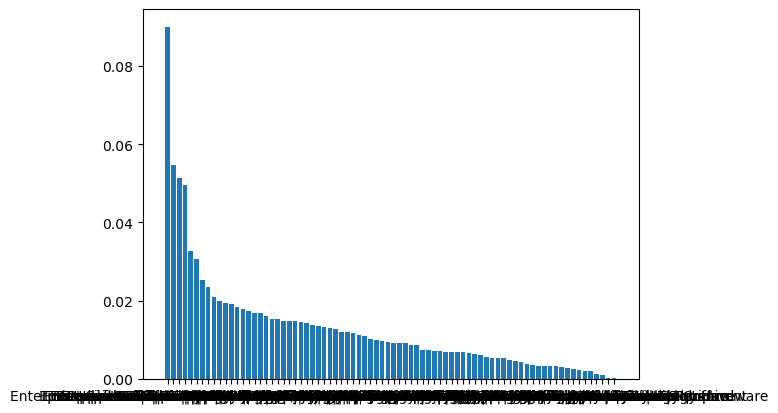

In [29]:
# distribution of sector label
dff['sector_label'] = dff.apply(lambda row: f"{row['sector']} | {row['sub_sector']}", axis=1)

v_counts = dff['sector_label'].value_counts(normalize=True).reset_index()
print(v_counts.columns)
plt.bar(x=v_counts[v_counts.columns[0]], height=v_counts[v_counts.columns[1]])

plt.show()

In [30]:
sector_value_counts_dict = dff['sector_label'].value_counts(normalize=True).to_dict()

def relabel(sector_label, min_proportion)->str:
    """Relabel based on a minimum proportion. If less than min proportion relabel as [Sector] | Other [Sector]"""
    if sector_value_counts_dict[sector_label] <= min_proportion:
        return f"{sector_label.split('|')[0]} | Other {sector_label.split('|')[0]}"
    else:
        return sector_label
    

dff['sector_relabel'] = dff['sector_label'].apply(lambda x: relabel(x,.01))

In [31]:
dff['sector_relabel'].value_counts()

Healthcare | BioTech & Pharma                                   401
Enterprise Software | Data Intelligence                         243
Enterprise Software | Sales & Marketing / Adtech                229
Consumer & Lifestyle  | Other Consumer & Lifestyle              227
Enterprise Software | Cybersecurity                             221
Industrial  | Other Industrial                                  180
FinTech  | Other FinTech                                        158
Consumer & Lifestyle | E-commerce                               145
Enterprise Software | Business Operations                       136
Transportation  | Other Transportation                          124
Healthcare | Digital Health                                     112
Enterprise Software | Other Enterprise Software                 104
Real Estate  | Other Real Estate                                 94
Enterprise Software | Data Management/Storage                    93
FinTech | Other Fintech                         

In [32]:
# set dataframe for prediction at sub sector level
dfs = dff[['description', 'sector_relabel', 'top_issuer']].copy()

dfs['encoded_labels'] = dfs['sector_relabel'].astype('category').cat.codes

data_texts = dfs['description'].to_list()
data_labels = dfs['encoded_labels'].to_list()

dfs.head()

,description,sector_relabel,top_issuer,encoded_labels
0,Accompany Health is a company aiming to combin...,Healthcare | Digital Health,0,32
1,Developer of drugs for the treatment of inflam...,Healthcare | BioTech & Pharma,0,31
2,Laser Light Communications is a telecommunicat...,Enterprise Software | Cloud/Networking Infrast...,0,12
3,Finastra is a fintech company focused on build...,FinTech | Other Fintech,0,27
4,"TigerGraph, founded in 2012, is the developer ...",Enterprise Software | Data Intelligence,1,15


In [33]:
# Stratify dataset when splitting
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state=23, stratify=data_labels)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.1, random_state=23, stratify=train_labels)

In [133]:
train_dict = {'train_labels': train_labels, 'train_texts': train_texts}

# Create DataFrame without specifying column names
data_train_output = pd.DataFrame(train_dict)

# data to use for training model in Sagemaker Jumpstart
data_train_output.to_csv('data.csv', header=None, index=False)

In [34]:
dfi = dfs[dfs['top_issuer']==1].reset_index(drop=True).copy()
top_issuers_texts = dfi['description'].to_list()
top_issuers_labels = dfi['encoded_labels'].to_list()

In [35]:
import tqdm as notebook_tqdm
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

d = {'train':Dataset.from_dict({'label':train_labels,'text':train_texts}),
     'val':Dataset.from_dict({'label':val_labels,'text':val_texts}),
     'test':Dataset.from_dict({'label':test_labels,'text':test_texts}),
     'top_issuers':Dataset.from_dict({'label':top_issuers_labels,'text':top_issuers_texts})
     }

sectors = DatasetDict(d)

In [36]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

2024-04-23 14:27:39.790070: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 14:27:39.844998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 14:27:41.013568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [37]:
model_id = "bert-base-uncased"
# model_id = "distilbert-base-uncased"
model = TFAutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

2024-04-23 14:27:43.999609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 14:27:44.472818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 14:27:44.476462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [38]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [39]:
sectors_encoded = sectors.map(tokenize, batched=True, batch_size=None)
sectors_encoded

Map:   0%|          | 0/3206 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

Map:   0%|          | 0/357 [00:00<?, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3206
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 891
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 357
    })
    top_issuers: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 279
    })
})

In [40]:
# setting 'input_ids', 'attention_mask', 'token_type_ids', and 'label'
# to the tensorflow format. Now if you access this dataset you will get these
# columns in `tf.Tensor` format

sectors_encoded.set_format('tf',
                            columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

# setting BATCH_SIZE to 64.
BATCH_SIZE = 8

def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(sectors_encoded['train'][:])
# train_dataset = tf.data.Dataset.from_tensor_slices(emotions_encoded['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE) # map the `order` function

# # ... doing the same for val set ...
val_dataset = tf.data.Dataset.from_tensor_slices(sectors_encoded['val'][:])
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(sectors_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for top issuers set ...
top_issuers_dataset = tf.data.Dataset.from_tensor_slices(sectors_encoded['top_issuers'][:])
top_issuers_dataset = top_issuers_dataset.batch(BATCH_SIZE)
top_issuers_dataset = top_issuers_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [41]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(8, 186), dtype=int64, numpy=
array([[  101,  8559, 12046, ...,     0,     0,     0],
       [  101, 10439,  5809, ...,     0,     0,     0],
       [  101, 24203,  2229, ...,     0,     0,     0],
       ...,
       [  101,  2598, 16344, ...,     0,     0,     0],
       [  101,  8292, 28228, ...,     0,     0,     0],
       [  101,  5506, 13808, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(8, 186), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 186), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} 

 tf.Tensor([21 11  2 14 33 20 22 27], s

In [42]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [43]:
num_classes = len(np.unique(dfs['sector_relabel']))
classifier = BERTForClassification(model, num_classes=num_classes)

classifier.compile(
    # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), # using the legacy TF-Keras optimizer instead
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [44]:
history = classifier.fit(
    train_dataset,
    epochs=3
)

Epoch 1/3
401/401 [==============================] - 177s 303ms/step - loss: 3.1343 - accuracy: 0.2202
Epoch 2/3
401/401 [==============================] - 122s 305ms/step - loss: 1.9503 - accuracy: 0.5006
Epoch 3/3
401/401 [==============================] - 122s 305ms/step - loss: 1.4655 - accuracy: 0.6104


In [45]:
# build encoded dict
dfs['encoded_tuple'] = dfs.apply(lambda row: (row['encoded_labels'], row['sector_relabel']), axis=1)

encoded_dict = {i[0]:i[1]  for i in np.unique(dfs['encoded_tuple'])}

#### Test set

In [143]:
test_predictions = classifier.predict(test_dataset)

45/45 [==============================] - 3s 75ms/step


In [144]:
k=5
test_predictions_output = [tf.math.argmax(array).numpy() for array in test_predictions]
test_pred_conf_output = [tf.nn.top_k(array, k=1).values.numpy()[0] for array in test_predictions]
test_top_k_predictions_output = [tf.nn.top_k(array, k=k).indices.numpy() for array in test_predictions]
test_top_k_predictions_conf_output = [tf.nn.top_k(array, k=k).values.numpy() for array in test_predictions]

In [160]:
dft = pd.DataFrame.from_dict({'description': test_texts,
                              'encoded_label': test_labels,
                              'encoded_pred': test_predictions_output,
                              'pred_conf': test_pred_conf_output,
                              'encoded_pred_list': test_top_k_predictions_output,
                              'pred_conf_list': test_top_k_predictions_conf_output
                              })

pred_list = []
for idx, row in dft.iterrows():
    int_pred_list = []
    for pred in row['encoded_pred_list']:
        int_pred_list.append(encoded_dict[pred])
        
    pred_list.append(int_pred_list)
    
    
dft['pred_list'] = pred_list

dft['sub_sector_label'] = dft['encoded_label'].apply(lambda x: encoded_dict[x])
dft['sub_sector_pred_label'] = dft['encoded_pred'].apply(lambda x: encoded_dict[x])

dft['sector_label'] = dft['sub_sector_label'].apply(lambda x: x.split('|')[0].strip())
dft['sector_pred_label'] = dft['sub_sector_pred_label'].apply(lambda x: x.split('|')[0].strip())

dft['sub_sector_match'] = dft['sub_sector_label']==dft['sub_sector_pred_label']
dft['sector_match'] = dft['sector_label']==dft['sector_pred_label']

dft['label_top_k'] = dft.apply(lambda row: 1 if row['encoded_label'] in row['encoded_pred_list'] else 0, axis=1)

print('Sub sector', np.mean(dft['sub_sector_match']))
print('Sector', np.mean(dft['sector_match']))
print(f'Label in top {k} predictions:', np.mean(dfv['label_top_k']))
conf_level = .75
print(f'Sub sector match (> {int(conf_level*100)}% confidence):',
      np.mean(dft[dft['pred_conf']>conf_level]['sub_sector_match']))
print(f'Sector match (> {int(conf_level*100)}% confidence):',
      np.mean(dft[dft['pred_conf']>conf_level]['sector_match']))

print(len(dft[dft['pred_conf']>conf_level]))
print(len(dft[dft['pred_conf']<=conf_level]))
dft.head()

Sub sector 0.5798319327731093
Sector 0.8263305322128851
Label in top 5 predictions: 0.8608305274971941
Sub sector match (> 75% confidence): 0.8505747126436781
Sector match (> 75% confidence): 0.9770114942528736
87
270


,description,encoded_label,encoded_pred,pred_conf,encoded_pred_list,pred_conf_list,pred_list,sub_sector_label,sub_sector_pred_label,sector_label,sector_pred_label,sub_sector_match,sector_match,label_top_k
0,Checkerspot is a San Francisco-based biotechno...,37,31,0.762189,"[31, 29, 30, 37, 36]","[0.7621888, 0.032272704, 0.023964187, 0.023616...","[Healthcare | BioTech & Pharma, FoodTech | Ot...",Industrial | Other Industrial,Healthcare | BioTech & Pharma,Industrial,Healthcare,False,False,1
1,CipherCloud is a provider of cloud security an...,14,14,0.824353,"[14, 16, 18, 12, 15]","[0.82435274, 0.03507265, 0.024594445, 0.020741...","[Enterprise Software | Cybersecurity, Enterpri...",Enterprise Software | Cybersecurity,Enterprise Software | Cybersecurity,Enterprise Software,Enterprise Software,True,True,1
2,Imperfect Foods is a grocery delivery service ...,30,29,0.366682,"[29, 30, 43, 4, 0]","[0.36668184, 0.32438862, 0.08087468, 0.0340783...","[FoodTech | Other FoodTech , FoodTech | Food ...",FoodTech | Food Products & Services,FoodTech | Other FoodTech,FoodTech,FoodTech,False,True,1
3,GridGain Systems is revolutionizing real-time ...,18,16,0.329658,"[16, 12, 21, 42, 19]","[0.32965773, 0.161718, 0.102092184, 0.08603163...",[Enterprise Software | Data Management/Storage...,Enterprise Software | Other Enterprise Software,Enterprise Software | Data Management/Storage,Enterprise Software,Enterprise Software,False,True,0
4,HealthJoy is a healthcare platform that serves...,34,33,0.388870,"[33, 32, 34, 36, 17]","[0.3888696, 0.24361216, 0.18662362, 0.02448872...","[Healthcare | Healthcare providers & services,...",Healthcare | Healthcare software,Healthcare | Healthcare providers & services,Healthcare,Healthcare,False,True,1


#### Validation set

In [135]:
val_predictions = classifier.predict(val_dataset)

112/112 [==============================] - 9s 76ms/step


In [138]:
k=5
val_predictions_output = [tf.math.argmax(array).numpy() for array in val_predictions]
val_pred_conf_output = [tf.nn.top_k(array, k=1).values.numpy()[0] for array in val_predictions]
val_top_k_predictions_output = [tf.nn.top_k(array, k=k).indices.numpy() for array in val_predictions]
val_top_k_predictions_conf_output = [tf.nn.top_k(array, k=k).values.numpy() for array in val_predictions]

In [154]:
dfv = pd.DataFrame.from_dict({'description': val_texts,
                              'encoded_label': val_labels,
                              'encoded_pred': val_predictions_output,
                              'pred_conf': val_pred_conf_output,
                              'encoded_pred_list': val_top_k_predictions_output,
                              'pred_conf_list': val_top_k_predictions_conf_output
                              })

pred_list = []
for idx, row in dfv.iterrows():
    int_pred_list = []
    for pred in row['encoded_pred_list']:
        int_pred_list.append(encoded_dict[pred])
        
    pred_list.append(int_pred_list)
    
    
dfv['pred_list'] = pred_list

dfv['sub_sector_label'] = dfv['encoded_label'].apply(lambda x: encoded_dict[x])
dfv['sub_sector_pred_label'] = dfv['encoded_pred'].apply(lambda x: encoded_dict[x])

dfv['sector_label'] = dfv['sub_sector_label'].apply(lambda x: x.split('|')[0].strip())
dfv['sector_pred_label'] = dfv['sub_sector_pred_label'].apply(lambda x: x.split('|')[0].strip())

dfv['sub_sector_match'] = dfv['sub_sector_label']==dfv['sub_sector_pred_label']
dfv['sector_match'] = dfv['sector_label']==dfv['sector_pred_label']

dfv['label_top_k'] = dfv.apply(lambda row: 1 if row['encoded_label'] in row['encoded_pred_list'] else 0, axis=1)

print('Sub sector', np.mean(dfv['sub_sector_match']))
print('Sector', np.mean(dfv['sector_match']))
print(f'Label in top {k} predictions:', np.mean(dfv['label_top_k']))
conf_level = .7
print(f'Sub sector match (> {int(conf_level*100)}% confidence):',
      np.mean(dfv[dfv['pred_conf']>conf_level]['sub_sector_match']))

print(len(dfv[dfv['pred_conf']>=conf_level]))
print(len(dfv[dfv['pred_conf']<conf_level]))

dfv.head()

Sub sector 0.5600448933782267
Sector 0.8069584736251403
Label in top 5 predictions: 0.8608305274971941
Sub sector match (> 70% confidence): 0.8518518518518519
243
648


,description,encoded_label,encoded_pred,pred_conf,encoded_pred_list,pred_conf_list,pred_list,sub_sector_label,sub_sector_pred_label,sector_label,sector_pred_label,sub_sector_match,sector_match,label_top_k
0,Jobber is a platform that seeks to deliver eff...,39,17,0.226589,"[17, 0, 20, 18, 11]","[0.22658862, 0.19437686, 0.107018344, 0.088923...","[Enterprise Software | Human Resources, Consum...",Industrial | Industrial software,Enterprise Software | Human Resources,Industrial,Enterprise Software,False,False,0
1,Cerapedics is a biotech company focused on dev...,31,31,0.726271,"[31, 36, 35, 33, 34]","[0.72627115, 0.09509118, 0.065350376, 0.021645...","[Healthcare | BioTech & Pharma, Healthcare | O...",Healthcare | BioTech & Pharma,Healthcare | BioTech & Pharma,Healthcare,Healthcare,True,True,1
2,Uhnder leads in digital perception radar techn...,44,44,0.242116,"[44, 37, 3, 38, 39]","[0.24211554, 0.10646261, 0.101207264, 0.067788...","[Transportation | Autonomous Vehicles, Industr...",Transportation | Autonomous Vehicles,Transportation | Autonomous Vehicles,Transportation,Transportation,True,True,1
3,Hexagon Bio is a developer of a data-driven sy...,31,31,0.982170,"[31, 34, 33, 36, 29]","[0.98216957, 0.0029243706, 0.001802174, 0.0016...","[Healthcare | BioTech & Pharma, Healthcare | H...",Healthcare | BioTech & Pharma,Healthcare | BioTech & Pharma,Healthcare,Healthcare,True,True,1
4,Esperanto Technologies is the developer of hig...,15,42,0.444448,"[42, 12, 3, 21, 9]","[0.44444793, 0.10386348, 0.10115489, 0.0359591...","[Technology Hardware | Computing hardware, Ent...",Enterprise Software | Data Intelligence,Technology Hardware | Computing hardware,Enterprise Software,Technology Hardware,False,False,0


### Priority 1 issuers

In [155]:
top_issuers_predictions = classifier.predict(top_issuers_dataset)

35/35 [==============================] - 3s 73ms/step


In [156]:
k=5
top_issuers_predictions_output = [tf.math.argmax(array).numpy() for array in top_issuers_predictions]
imp_issuers_pred_conf_output = [tf.nn.top_k(array, k=1).values.numpy()[0] for array in top_issuers_predictions]
imp_issuers_top_k_predictions_output = [tf.nn.top_k(array, k=k).indices.numpy() for array in top_issuers_predictions]
imp_issuers_top_k_predictions_conf_output = [tf.nn.top_k(array, k=k).values.numpy() for array in top_issuers_predictions]

In [162]:
dfii = pd.DataFrame.from_dict({'description': top_issuers_texts,
                              'encoded_label': top_issuers_labels,
                              'encoded_pred': top_issuers_predictions_output,
                              'pred_conf': imp_issuers_pred_conf_output,
                              'encoded_pred_list': imp_issuers_top_k_predictions_output,
                              'pred_conf_list': imp_issuers_top_k_predictions_conf_output
                              })

pred_list = []
for idx, row in dfii.iterrows():
    int_pred_list = []
    for pred in row['encoded_pred_list']:
        int_pred_list.append(encoded_dict[pred])
        
    pred_list.append(int_pred_list)
    
    
dfii['pred_list'] = pred_list

dfii['sub_sector_label'] = dfii['encoded_label'].apply(lambda x: encoded_dict[x])
dfii['sub_sector_pred_label'] = dfii['encoded_pred'].apply(lambda x: encoded_dict[x])

dfii['sector_label'] = dfii['sub_sector_label'].apply(lambda x: x.split('|')[0].strip())
dfii['sector_pred_label'] = dfii['sub_sector_pred_label'].apply(lambda x: x.split('|')[0].strip())

dfii['sub_sector_match'] = dfii['sub_sector_label']==dfii['sub_sector_pred_label']
dfii['sector_match'] = dfii['sector_label']==dfii['sector_pred_label']

dfii['label_top_k'] = dfii.apply(lambda row: 1 if row['encoded_label'] in row['encoded_pred_list'] else 0, axis=1)

print('Sub sector', np.mean(dfii['sub_sector_match']))
print('Sector', np.mean(dfii['sector_match']))
print(f'Label in top {k} predictions:', np.mean(dfii['label_top_k']))
conf_level = .75
print(f'Sub sector match (> {int(conf_level*100)}% confidence):',
      np.mean(dfii[dfii['pred_conf']>conf_level]['sub_sector_match']))
print(f'Sector match (> {int(conf_level*100)}% confidence):',
      np.mean(dfii[dfii['pred_conf']>conf_level]['sector_match']))

print(len(dfii[dfii['pred_conf']>conf_level]))
print(len(dfii[dfii['pred_conf']<=conf_level]))

dfii.head()

Sub sector 0.7526881720430108
Sector 0.910394265232975
Label in top 5 predictions: 0.967741935483871
Sub sector match (> 75% confidence): 0.9807692307692307
Sector match (> 75% confidence): 0.9807692307692307
52
227


,description,encoded_label,encoded_pred,pred_conf,encoded_pred_list,pred_conf_list,pred_list,sub_sector_label,sub_sector_pred_label,sector_label,sector_pred_label,sub_sector_match,sector_match,label_top_k
0,"TigerGraph, founded in 2012, is the developer ...",15,15,0.749062,"[15, 16, 11, 14, 18]","[0.7490622, 0.06679267, 0.03885333, 0.02464948...","[Enterprise Software | Data Intelligence, Ente...",Enterprise Software | Data Intelligence,Enterprise Software | Data Intelligence,Enterprise Software,Enterprise Software,True,True,1
1,"Dandy, founded in 2020, is a health technology...",33,33,0.459383,"[33, 32, 34, 35, 36]","[0.45938343, 0.20756637, 0.096909635, 0.051738...","[Healthcare | Healthcare providers & services,...",Healthcare | Healthcare providers & services,Healthcare | Healthcare providers & services,Healthcare,Healthcare,True,True,1
2,Mapbox is a real-time location platform for lo...,21,21,0.160283,"[21, 15, 19, 20, 18]","[0.16028343, 0.14721647, 0.08800843, 0.0832591...","[Enterprise Software | Software Development, E...",Enterprise Software | Software Development,Enterprise Software | Software Development,Enterprise Software,Enterprise Software,True,True,1
3,"Color, founded in 2015, is a population health...",33,33,0.291066,"[33, 32, 34, 31, 36]","[0.2910661, 0.2209243, 0.14571589, 0.14263979,...","[Healthcare | Healthcare providers & services,...",Healthcare | Healthcare providers & services,Healthcare | Healthcare providers & services,Healthcare,Healthcare,True,True,1
4,"Brex, founded in 2017 by Henrique Dubugras and...",26,22,0.461413,"[22, 28, 27, 26, 11]","[0.46141288, 0.18916781, 0.102446444, 0.102124...","[FinTech | Other FinTech , FinTech | Payments...",FinTech | Lending,FinTech | Other FinTech,FinTech,FinTech,False,True,1


In [90]:
import seaborn as sns

In [171]:
# print(dfii['sub_sector_label'].iloc[0])
# print(dfii['description'].iloc[0])
# print(dfii['pred_list'].iloc[0])
# print(dfii['pred_conf_list'].iloc[0])

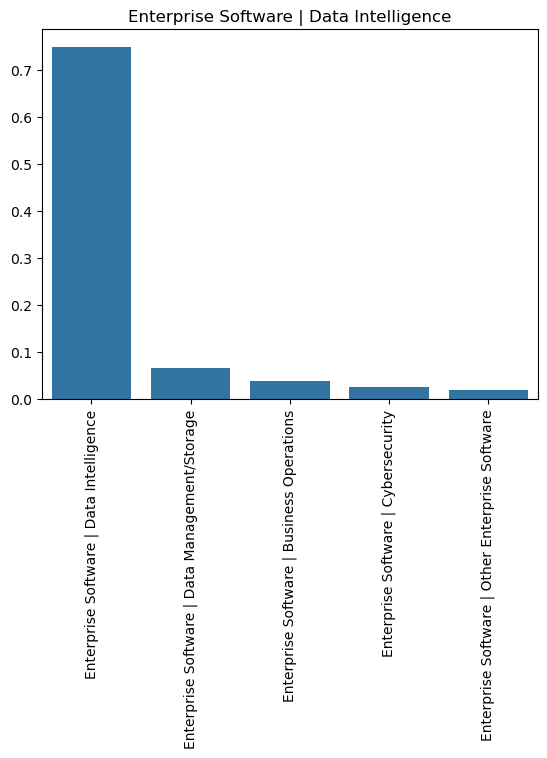

In [102]:
sns.barplot(x=dfii['pred_list'].iloc[0], y=dfii['pred_conf_list'].iloc[0])
plt.title(f"{dfii['sub_sector_label'].iloc[0]")
plt.xticks(rotation=90)
plt.show()